# **Number detection algorithm**

## **Introduction**

This work 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import cv2 as cv
from scipy import ndimage
import os

In [2]:
class Digit:
    def __init__(self, data, target):
        self.target = target
        self.width  = int(np.sqrt(len(data)))
        self.image  = data.reshape(self.width, self.width)
        self.features = {'var' : 0,
                         'std' : 0,
                         'mean_grad_M' : 0,
                         'std_grad_M'  : 0,
                         'mean_grad_D' : 0,
                         'std_grad_D'  : 0,
                         'mean_PC_X'   : 0,
                         'std_PC_X'    : 0,
                         'active_PC_X' : 0,
                         'mean_PC_Y'   : 0,
                         'std_PC_Y'    : 0,
                         'active_PC_Y' : 0}
        self.computeFeatures()
    
    def computeFeatures(self):
        # Feature computation
        mag, ang = sobel(self.image)
        pcx, pcy = pixel_count(self.image)
        
        self.features['var'] = np.var(self.image)
        self.features['std'] = np.std(self.image)
        self.features['mean_grad_M'] = np.mean(mag)
        self.features['std_grad_M'] =  np.std(mag)
        self.features['mean_grad_D'] = np.mean(ang)
        self.features['std_grad_D'] =  np.std(ang)
        self.features['mean_PC_X'] =   np.mean(pcx)
        self.features['std_PC_X'] =    np.std(pcx)
        self.features['active_PC_X'] = np.count_nonzero(pcx)
        self.features['mean_PC_Y'] =   np.mean(pcy)
        self.features['std_PC_Y'] =    np.std(pcy)
        self.features['active_PC_Y'] = np.count_nonzero(pcy) 
  
    def __print__(self):
        print("Digit target: "+str(self.target))
        print("Digit features:")
        print(self.features)
        print("Digit image:")
        plt.gray()
        plt.matshow(self.image) 
        plt.show() 

#### **Feature extraction functions**


In [3]:
def sobel(image):
    w = len(image)
    kernel_x = np.array([ [ 1, 0,-1],
                          [ 2, 0,-2],
                          [ 1, 0,-1] ])

    kernel_y = np.array([ [ 1, 2, 1],
                          [ 0, 0, 0],
                          [-1,-2,-1] ])
    
    grad_x = np.zeros([w - 2, w - 2])
    grad_y = np.zeros([w - 2, w - 2])
    
    for i in range(w - 2):
        for j in range(w - 2):
            grad_x[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_x))
            grad_y[i, j] = sum(sum(image[i : i + 3, j : j + 3] * kernel_y))
            if grad_x[i, j] == 0:
                grad_x[i, j] = 0.000001
    
    mag = np.sqrt(grad_y ** 2 + grad_x ** 2)
    ang = np.arctan(grad_y / (grad_x + np.finfo(float).eps))
  
    # Gradient computation
  
    return [mag,ang]

def pixel_count(image):
    pc_x = np.zeros(len(image))
    pc_y = np.zeros(len(image))
  
    # Pixel count computation
    for i in range(len(image)):
        pc_x[i] = np.count_nonzero(image[i, :])
        pc_y[i] = np.count_nonzero(image[:, i])

    return [pc_x, pc_y]

In [4]:
class Dataset:
    def __init__(self, filename, length):  
        self.filename = filename
        if length == -1:
            with open(self.filename, 'r') as csvfile:
                spamreader = csv.reader(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_NONNUMERIC) 
                self.length = sum(1 for row in spamreader)
        else: 
            self.length = length
            self.digits = []
        self.digits = self.createDigits()
        self.raw_features = [[float(f) for f in dig.features.values()] for dig in self.digits]
        self.raw_targets  = [[self.digits[i].target] for i in range(self.length)]
  
    def createDigits(self):
        # Parse the csv file row by row and create Digits on the fly
        digits = []
        with open(self.filename, 'r') as csvfile:
            spamreader = csv.reader(csvfile, delimiter = ',', quotechar = '|', quoting = csv.QUOTE_NONNUMERIC)
            for i, row in enumerate(spamreader):
                if i == self.length: break
                digits.append(Digit(np.array(row[:-1]), row[-1]))
                
        return digits
    

#### **Image Generation**

Just to change the image format, color, etc...

In [71]:
image_path_1 = os.getcwd() + '/chiffres/Numero1/'
image_path_2 = os.getcwd() + '/chiffres/Numero2/'
image_path_3 = os.getcwd() + '/chiffres/Numero3/'
image_path_4 = os.getcwd() + '/chiffres/Numero4/'
image_path_5 = os.getcwd() + '/chiffres/Numero5/'
image_path_6 = os.getcwd() + '/chiffres/Numero6/'

image_path_chiffre = image_path_6
chiffre = image_path_chiffre[-2]

image_list = []
for x in os.listdir(image_path_chiffre):
    path_image = image_path_chiffre + x
    im = cv.imread(path_image, 0)
    image_list.append(im)
    
if os.path.isfile('test.csv'):
    os.remove('test.csv')
else:
    print 'file does not exist'
    
for im in image_list:

    inutile, thresh = cv.threshold(im, 225, 255, cv.THRESH_BINARY_INV)
    imgBGR = cv.cvtColor(im, cv.COLOR_GRAY2BGR)

    #imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    #ret2, thresh = cv.threshold(im[1::], 127, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    #imgray = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    #ret, thresh = cv.threshold(imgray, 127, 255, 0)
    contours, hierarchy = cv.findContours(thresh, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    #plt.imshow(im, cmap='gray')

    size=len(contours)
    for i in range(0,size):
        #Calcul de l'aire de la zone
        diceContourArea = cv.contourArea(contours[i])
        #print(diceContourArea)
        if diceContourArea>20 and diceContourArea<250:
            #print(diceContourArea)

            #rect = cv.minAreaRect(contours[i])
            #box = cv.boxPoints(rect)
            #box = np.int0(box)
            #cv.drawContours(imgBGR,[box],0,(0,0,255),2)

            x,y,w,h=cv.boundingRect(contours[i])#calcul des coordonnées de la zone
            cv.rectangle(imgBGR,(x,y),(x+w,y+h),(255,255,0),2)#affiche les rectangles sur l'image binaire
            diceROI = thresh[y-2:y+h+2,x-2:x+w+2]#extraction de la zone sur l'image

    #inutile, threshFinal = cv.threshold(imgBGR, 225, 255, cv.THRESH_BINARY_INV)        

    #inutile2, threshFinal = cv.threshold(diceROI, 225, 255, cv.THRESH_BINARY_INV)   
    #plt.imshow(diceROI, cmap='gray')

    #print int(ndimage.measurements.center_of_mass(diceROI)[0])
    #print int(ndimage.measurements.center_of_mass(diceROI)[1])

    centre_h, centre_w = ndimage.measurements.center_of_mass(diceROI)
    h, w = diceROI.shape
    n = 56
    black_image = np.zeros((n,n))
    
    # print black_image.shape

    black_image[int((n-h)/2):int(((n-h)/2)+h),int((n-w)/2):int(((n-w)/2)+w)] = diceROI 


    #plt.imshow(black_image, cmap='gray')
    scale_percent = 50 # percent of original size
    width = int(black_image.shape[1] * scale_percent / 100)
    height = int(black_image.shape[0] * scale_percent / 100)
    dim = (width, height)
    # resize image
    resized = cv.resize(black_image, dim, interpolation = cv.INTER_AREA)
    #sortie = cv.resize(diceROI, None, fx = int(diceROI.shape[0]/20), fy = int(diceROI.shape[1]/20), interpolation = cv.INTER_CUBIC)


    A = np.asarray(resized).reshape(-1)

    row = []
    for result in A:
        row.append(result)

    row.append(float(chiffre))
    
    with open('test.csv', "a") as file:
        writer = csv.writer(file)
        writer.writerow(row)

if os.path.isfile('test.csv'):
    print "END"
else:
    print 'file does not exist'  


END


#### **Dataset Generation**

Considering the long time necessary to compute the features of the entire dataset, it is recommended to only use a small part of the given csv file, although a large enough training set is necessary to train the model. The recommended values are 1800 and 600 for the training and testing sets, respectively.

In [40]:
print("Creating training set")
with open("mnist_trainset.csv") as f:
    lines = sum(1 for line in f)
    print lines 
    
print int(0.1*lines)
training_set = Dataset("mnist_trainset.csv",int(0.1*lines))

print("\nCreating testing set")
with open("mnist_testset.csv") as f:
    lines = sum(1 for line in f)
    print lines 
    
print int(0.2*lines)
testing_set = Dataset("mnist_testset.csv", int(0.2 * lines))

print "\nFinished creating datasets"

Creating training set
17181
1718

Creating testing set
2832
566

Finished creating datasets


In [72]:
print("Creating new testing set")

with open('test.csv') as f:
    lines = sum(1 for line in f)
    
new_testing_set = Dataset("test.csv",lines)
print new_testing_set

Creating new testing set
<__main__.Dataset instance at 0x7f97acf331b8>


In [73]:
def cvt_obj_nparray(dataset):
    X = np.zeros((dataset.length, 12))
    Y = np.zeros((dataset.length,))
    for i, digit in enumerate(dataset.digits):
        Y[i] = digit.target
        for j, feature in enumerate(digit.features):
            X[i, j] = digit.features[feature]
    return X, Y

Xtrain, Ytrain = cvt_obj_nparray(training_set)
Xtest, Ytest = cvt_obj_nparray(testing_set)
Xtrain2, Ytrain2 = cvt_obj_nparray(new_testing_set)

##### **Feature computation verification**

Verify that the features have been correctly computed before continuing the lab.

Digit target: 6.0
Digit features:
{'std_grad_M': 255.72553691238832, 'mean_grad_D': 4.868786291903792e-05, 'std_grad_D': 0.29670771059829115, 'var': 2203.1744483906446, 'active_PC_X': 7, 'active_PC_Y': 6, 'std': 46.937985133478456, 'std_PC_X': 2.2812456318101875, 'std_PC_Y': 2.4907993963089563, 'mean_grad_M': 81.99709364084357, 'mean_PC_Y': 1.2857142857142858, 'mean_PC_X': 1.2857142857142858}
Digit image:


<Figure size 432x288 with 0 Axes>

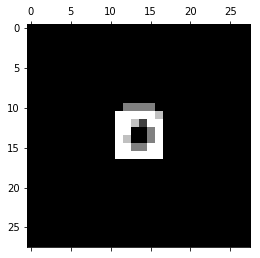

Digit target: 6.0
Digit features:
{'std_grad_M': 253.46276925599386, 'mean_grad_D': -0.011438904419298332, 'std_grad_D': 0.2939771728121607, 'var': 2172.071929257991, 'active_PC_X': 7, 'active_PC_Y': 6, 'std': 46.605492479513515, 'std_PC_X': 2.3307505141442473, 'std_PC_Y': 2.5642260239769845, 'mean_grad_M': 81.3954386100758, 'mean_PC_Y': 1.3214285714285714, 'mean_PC_X': 1.3214285714285714}
Digit image:


<Figure size 432x288 with 0 Axes>

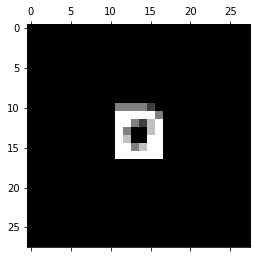

Digit target: 6.0
Digit features:
{'std_grad_M': 279.2827052394526, 'mean_grad_D': -0.009440988216897888, 'std_grad_D': 0.3785419257921384, 'var': 2670.3668164591245, 'active_PC_X': 7, 'active_PC_Y': 8, 'std': 51.67559207652221, 'std_PC_X': 3.01251640693305, 'std_PC_Y': 2.726242461554671, 'mean_grad_M': 102.21857595422365, 'mean_PC_Y': 1.6785714285714286, 'mean_PC_X': 1.6785714285714286}
Digit image:


<Figure size 432x288 with 0 Axes>

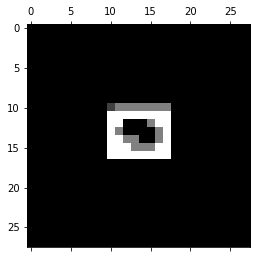

In [74]:
for i in range(len(new_testing_set.digits)):
    new_testing_set.digits[i].__print__()

#### **Classifier Training**

In this section, you will have to initialize a Decision Tree classifier and train it with the generated training set. As a first step, set the **maximum depth** of the Decision Tree **equal to 2**.

To quickly assess the quality of the trained model, you will compute the prediction accuracy on both the training and testing datasets.

*Useful functions &Rightarrow; DecisionTreeClassifier and DecisionTreeClassifier.fit()*

In [76]:
from sklearn.tree import DecisionTreeClassifier
# Decision Tree initialization
clf = DecisionTreeClassifier(random_state = 0, max_depth = 2)

print("Training classifier")
# Training Decision Tree
clf.fit(Xtrain, Ytrain)

acc_train = clf.score(Xtrain, Ytrain)
print("Score on training set: {}".format(acc_train))
# Compute prediction accuracy on training set

acc_test = clf.score(Xtest, Ytest)
print("Score on testing set: {}".format(acc_test))
# Compute prediction accuracy on testing set

acc_new_test = clf.score(Xtrain2, Ytrain2)
print("Score on new testing set: {}".format(acc_new_test))
# Compute prediction accuracy on new testing set

Training classifier
Score on training set: 0.647264260768
Score on testing set: 0.574204946996
Score on new testing set: 1.0


#### **Prediction**


In [70]:
y_pred = clf.predict(Xtrain2)
i = 0
for prediction in y_pred:
    if prediction != float(chiffre):
        print "\nThe number predicted was: {}".format(y_pred[i]) + " but the anwser should be: {}".format(float(chiffre)) + '\n'
        new_testing_set.digits[i].__print__()
    i+=1

##### **Parameter tuning**

In any machine learning problem, tuning the parameters defining the classifier model is an important step. In our simple classification problem, we will only study the optimal maximum_depth of the decision tree. In this cell, test various values for the depth of the tree, and display the accuracy on both training and testing datasets as a function of the depth.

*Useful functions &Rightarrow; plt.plot(), plt.title(), plt.xlabel(), plt.ylabel(), plt.legend()*

In [3]:
# Model training and accuracy computation for different maximum_depth parameters
tree_depth = [i for i in range(2, 30)]
accs_train = []
accs_test  = []

for depth in tree_depth:
    clf = DecisionTreeClassifier(random_state = 0, max_depth = depth)
    clf.fit(Xtrain, Ytrain)
    accs_train.append(clf.score(Xtrain, Ytrain))
    accs_test.append(clf.score(Xtest, Ytest))
plt.figure(figsize=(16, 8))

# Draw accuracies as a function of the depth for both trainin and testing sets
plt.plot(tree_depth, accs_train, label = 'Train Accuracy')
plt.plot(tree_depth, accs_test,  label = 'Test Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Tree Depth')
plt.legend()
plt.xticks(tree_depth)
plt.show()  

NameError: name 'DecisionTreeClassifier' is not defined

In [1]:
tree_depth[np.argmax(accs_test)]

NameError: name 'tree_depth' is not defined

##### **Analysis of the trained model**

Once you have found the depth value offering the best trade-off between complexity and accuracy, retrain your final model that will be analyzed in the remaining of the lab.

To further analyze the performances or your model, a useful tool for a classification problem is the confusion matrix. This allows you to quickly assess the quality of your model by displaying the amount of each possible prediction outcome, the diagonal cells corresponding to accurate predictions while other cells correspond to prediction errors.

The code of the function to plot this confusion matrix is given in a cell at the end of the notebook (simply run the cell to use the function).

Parameters to give to the **plot_confusion_matrix** function:
* confusion matrix (obtained with the confusion_matrix matrix from module sklearn.metrics)
* list of class labels
* title of the figure plot

*Useful functions &Rightarrow; DecisionTreeClassifier.predict() and confusion_matrix()*

In [14]:
opt_clf = DecisionTreeClassifier(random_state = 0, max_depth = 8)
opt_clf.fit(Xtrain, Ytrain)
Ypred_train = opt_clf.predict(Xtrain)
Ypred_test = opt_clf.predict(Xtest)

In [48]:
count = 0

for diff in (Ypred_test[1:1000] - Ypred_train[1:1000]):
    if diff == 0:
        count = count +1

print(float(count / 100))


3.0


##### **plot_confusion_matrix**

In [11]:
import itertools
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

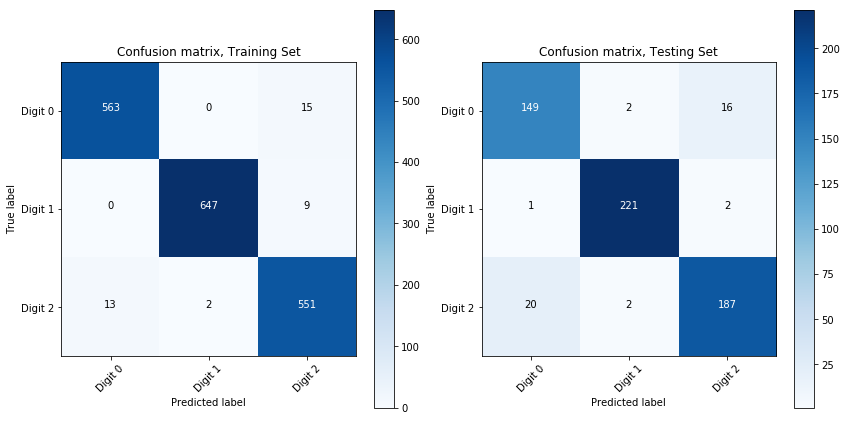

In [12]:
from sklearn.metrics import confusion_matrix

class_names = ['Digit 0', 'Digit 1', 'Digit 2']
plt.figure(figsize=(12,6))

# Computation of confusion matrix on training set
cm = confusion_matrix(Ytrain, Ypred_train)
plt.subplot(121)
plot_confusion_matrix(cm, classes=class_names,title='Confusion matrix, Training Set')

# Computation of confusion matrix on testing set
cm = confusion_matrix(Ytest, Ypred_test)
plt.subplot(122)
plot_confusion_matrix(cm, classes=class_names,title='Confusion matrix, Testing Set')
plt.show()

##### **Feature importance**

Another important step in classical machine learning problems is to limit as much as possible the number of features in order to reduce the complexity of the model. To do so, since you already trained the classifier with all the computed features, you can simply assess the importance of each feature in the trained model. 

Each classifier has an attribute ***feature_importance*** that contains an array representing the importance of each feature. The importance represents the ability of the feature to split the dataset in a meaningful manner. A value close to 1 means that the feature is good to discriminate the classes comprising the dataset, while a value close to 0 shows that the feature has not been selected during the training process due to its poor splitting ability.


In this cell, you will retrieve this information and generate a bar diagram with the feature names as bins and the feature importances as values.

*Useful functions &Rightarrow; ax.bar(), ax.set_xticks(), ax.set_xticklabels() (usage &rightarrow; ax.set_xticklabels(label_list, rotation=45, ha='right'))*

In [14]:
importance = opt_clf.feature_importances_
print(importance)

[0.10143666 0.01485306 0.65580337 0.00584452 0.01330006 0.00795959
 0.00819664 0.00827138 0.03090649 0.11432224 0.01548084 0.02362516]


[Text(0,0,'std_grad_M'),
 Text(0,0,'mean_grad_D'),
 Text(0,0,'std_grad_D'),
 Text(0,0,'var'),
 Text(0,0,'active_PC_X'),
 Text(0,0,'active_PC_Y'),
 Text(0,0,'std'),
 Text(0,0,'std_PC_X'),
 Text(0,0,'std_PC_Y'),
 Text(0,0,'mean_grad_M'),
 Text(0,0,'mean_PC_Y'),
 Text(0,0,'mean_PC_X')]

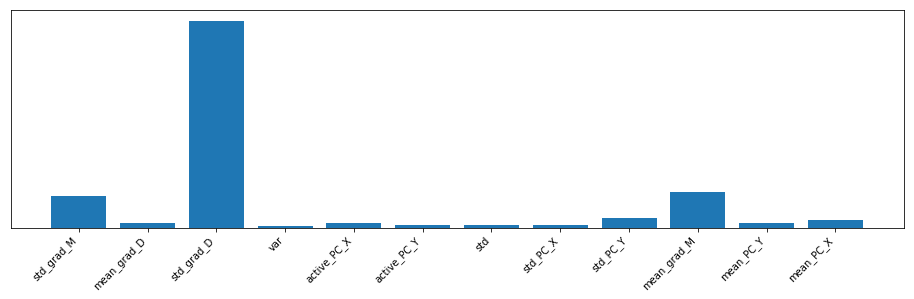

In [15]:
bins = np.arange(len(training_set.digits[0].features))
label_list = []
for feature in training_set.digits[0].features:
    label_list.append(feature)

plt.figure(figsize=(16,4))
ax = plt.subplot(111)
ax.bar(bins, importance)
ax.set_xticks(np.arange(len(label_list)))
ax.set_yticks([])
ax.set_xticklabels(label_list, rotation = 45, ha = 'right')
# Display bar graph of feature importances with feature names as labels